# Download waypoints from camptocamp.org of the Mt-Blanc region

In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
from bs4 import BeautifulSoup
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import re

In [56]:
url_c2c_api = 'https://api.camptocamp.org'
# Max 100 per request
page_len = 100

def get_url_waypoints(area, offset):
    return url_c2c_api + f'/waypoints?a={area}&limit=100&offset={offset}'

def get_url_routes(area, offset):
    return url_c2c_api + f'/routes?a={area}&limit=100&offset={offset}'

def get_url_route(id, lang='fr'):
    return url_c2c_api + f'/routes/{id}?cook={lang}'

In [173]:
def strip_html(html):
    if html is not None:
        return ' '.join(BeautifulSoup(html).findAll(text=True))
    else:
        return ''

def read_field(doc, field, default=''):
    if field in doc.keys():
        return doc[field]
    else:
        return default

def read_route(id):
    """ Get and extract wanted information from a route """
    route_doc = req.get(get_url_route(id)).json()
    
    activities = read_field(route_doc, 'activities', [])
    configuration = read_field(route_doc, 'configuration', [])
    
    # cooked already in 'fr'
    title = strip_html(read_field(route_doc['cooked'], 'title_prefix') + read_field(route_doc['cooked'], 'title'))
    description = strip_html(read_field(route_doc['cooked'], 'description'))
    return dict(id=id, title_fr=title, activities=activities, configuration=configuration, description_fr=description)

In [256]:
cols = ['id', 'title_fr', 'activities', 'configuration', 'description_fr']

In [390]:
def process_area_routes(area_id, area_title):

    df_routes = pd.DataFrame(columns=cols)

    # Get first page in order to get total number of routes
    page_offset = 0
    route_list = req.get(get_url_routes(area_id, page_offset)).json()
    nb_routes = route_list['total']
    print('Number of routes %d for %s' %(nb_routes, area_title))

    # Iterate
    cnt_routes = 0
    cnt_iter = 0
    while cnt_routes < nb_routes and cnt_iter < 1000:
        rows = []
        for route_doc in route_list['documents']:
            route_data = read_route(route_doc['document_id'])
            rows.append(route_data)
            cnt_routes += 1
        df_routes = df_routes.append(rows)
        page_offset += len(route_list['documents'])
        print('page offset:', page_offset)
        route_list = req.get(get_url_routes(area_id, page_offset)).json()
        cnt_iter += 1

    print('download completed')
    # Handle N/A
    empty_config = df_routes['configuration'].isnull() | (df_routes['configuration'] == '')
    df_routes.loc[empty_config, 'configuration'] = [[] for i in range(empty_config.sum())]
    print('data cleaned')
    df_routes.to_parquet(f'data/routes_details_{area_title}.parquet', compression='GZIP')
    print('data saved to Parquet file')
    
    return df_routes

In [392]:
#process_area_routes(14410, 'mt-blanc')
#process_area_routes(14411, 'chablais')
#process_area_routes(14417, 'aravis')
process_area_routes(14366, 'haute-savoie')
process_area_routes(14295, 'savoie')
process_area_routes(14328, 'isere')
process_area_routes(14361, 'hautes-alpes');

Number of routes 3911 for haute-savoie
page offset: 100
page offset: 200
page offset: 300
page offset: 400
page offset: 500
page offset: 600
page offset: 700
page offset: 800
page offset: 900
page offset: 1000
page offset: 1100
page offset: 1200
page offset: 1300
page offset: 1400
page offset: 1500
page offset: 1600
page offset: 1700
page offset: 1800
page offset: 1900
page offset: 2000
page offset: 2100
page offset: 2200
page offset: 2300
page offset: 2400
page offset: 2500
page offset: 2600
page offset: 2700
page offset: 2800
page offset: 2900
page offset: 3000
page offset: 3100
page offset: 3200
page offset: 3300
page offset: 3400
page offset: 3500
page offset: 3600
page offset: 3700
page offset: 3800
page offset: 3900
page offset: 3911
download completed
data cleaned
data saved to Parquet file
Number of routes 3221 for savoie
page offset: 100
page offset: 200
page offset: 300
page offset: 400
page offset: 500
page offset: 600
page offset: 700
page offset: 800
page offset: 900
page 

,id,title_fr,activities,configuration,description_fr
0,1206778,"Saint Pancrasse (le Luisset) voie ""On or in""",[rock_climbing],[],8 points dans la voie \nRelais sur 2 points ch...
1,1205974,Tête de l'Ours Délice de Tulip,[rock_climbing],[face],Approche \n Voie \n \n \n \n L 1 \n 5c \n \n \...
2,1205914,"Petit Som En boucle depuis la Correrie, retour...",[hiking],[],Départ du parking à côté du Musée vers le GRP ...
3,1202566,Refuge Temple Écrins depuis La Bérarde,[hiking],[],"De La Bérarde, suivre le chemin qui remonte la..."
4,1201500,Rocher Blanc Arête S par le Col de l'Amiante -...,[skitouring],[],"Montée \n Du parking, traverser le pont pour r..."
...,...,...,...,...,...
13,45230,Col de Morétan Versant W,[skitouring],[],Versant W du vallon du Gleyzin \n \n Montée \n...
14,45217,Col de Burlan Couloir N,"[skitouring, snow_ice_mixed]",[corridor],"\n Approche \n Depuis le parking , emprunter ..."
15,45193,Pointe de Vaudaine Versant W,[skitouring],"[face, corridor]",Accès au Lacs Robert \n Plusieurs possibilités...
16,45164,Col de Roche Noire Versant E,[skitouring],[face],Montée \n Roche Noire - Col de Roche Noire - R...


### Transform activities and configuration into 1 hot

In [513]:
all_routes = pd.concat([pd.read_parquet('data/routes_details_haute-savoie.parquet'),
                        pd.read_parquet('data/routes_details_savoie.parquet'), 
                        pd.read_parquet('data/routes_details_isere.parquet'),
                        pd.read_parquet('data/routes_details_hautes-alpes.parquet')])
all_routes.shape

(14074, 5)

### Remove routes without description

They are easy to spot as a quality issue and are not useful for predictions on text

In [514]:
print('Number of routes with no description: %d' % (all_routes.description_fr.str.len() == 0).sum())
all_routes = all_routes[all_routes.description_fr.str.len() > 0]
all_routes.shape

Number of routes with no description: 610


(13464, 5)

### Create 1 hot encoded columns for activities

Possibly more than 1 activity per route

In [515]:
mlb = MultiLabelBinarizer()
activities_1hot = mlb.fit_transform(all_routes.activities)
activities_cols = mlb.classes_
configuration_1hot = mlb.fit_transform(all_routes.configuration)
configuration_cols = mlb.classes_

all_routes = pd.concat([all_routes, 
                        pd.DataFrame(activities_1hot, columns=activities_cols, index=all_routes.index),
                        pd.DataFrame(configuration_1hot, columns=configuration_cols, index=all_routes.index)], 
                       axis=1)

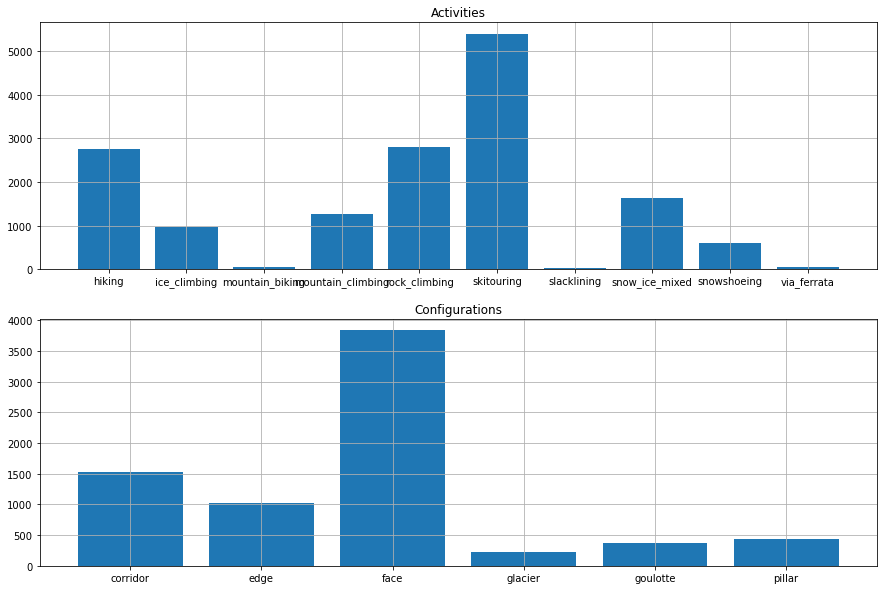

In [516]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes[0]
ax.bar(activities_cols, all_routes[activities_cols].sum());
ax.set_title('Activities')
ax.grid()
ax = axes[1]
ax.bar(configuration_cols, all_routes[configuration_cols].sum());
ax.set_title('Configurations');
ax.grid()

In [499]:
def clean_and_tokenize(text):
    text = re.sub('[;,:\!\?\.\(\)\n]', ' ', text).replace('[\s+]', ' ')
    return nltk.word_tokenize(text)

sequences = all_routes.apply(lambda row: clean_and_tokenize(row['description_fr']), axis=1)

In [500]:
print(sequences.iloc[6])

['Montée', 'Depuis', 'le', 'Dérochoir', 'longer', 'la', 'crête', 'entre', 'la', 'Pointe', 'du', 'Dérochoir', 'et', 'la', 'Pointe', 'de', 'Platé', 'Depuis', 'les', 'chalets', 'de', 'Platé', 'se', 'diriger', 'vers', 'la', 'base', 'de', 'la', 'face', 'E', 'de', 'la', 'Pointe', 'de', 'Platé', 'Repérer', 'la', 'cheminée', 'dans', 'la', 'face', "S'engager", 'dedans', 'et', 'la', 'gravir', "jusqu'au", 'sommet', 'IV', 'sup', 'en', 'rocher', 'délité', 'Descente', 'Par', "l'arête", 'N', 'et', 'avec', 'sa', 'variante', 'du', 'Sphinx', 'ou', 'la', 'face', 'W', 'Possibilité', 'de', 'descendre', 'aussi', 'par', "l'arête", 'S', 'et/ou', 'le', 'couloir', 'du', 'Gypaète', 'La', 'descente', 'par', 'cet', 'itinéraire', 'est', 'hasardeuse', 'Il', 'est', 'possible', 'de', 'passer', 'par', 'les', 'vires', 'et', 'gradins', 'de', "l'arête", 'E', 'plus', 'faciles', 'mais', "l'exposition", 'y', 'est', 'autant', 'voire', 'plus', 'forte']


In [506]:
sequences.str.len().quantile([0.02, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.02      3.00
0.10     50.00
0.20     80.00
0.30    106.00
0.50    163.00
0.60    197.00
0.70    241.00
0.80    305.00
0.90    424.00
0.95    537.00
0.99    851.48
dtype: float64

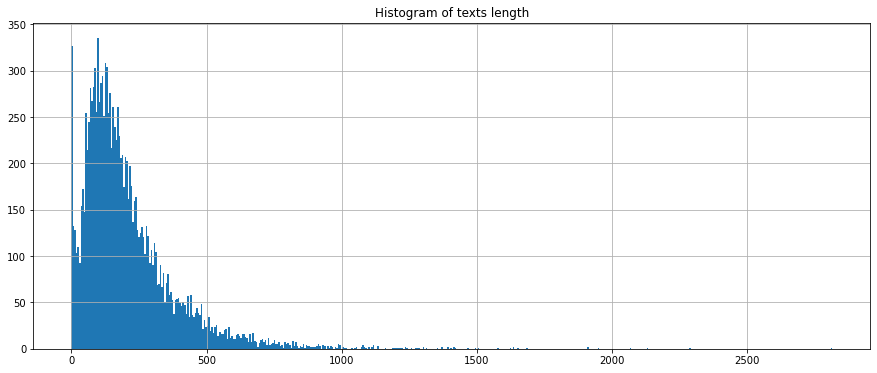

In [507]:
fig, ax = plt.subplots(figsize=(15, 6))
sequences.str.len().hist(bins=500, ax=ax)
ax.set_title('Histogram of texts length');

In [508]:
pd.DataFrame(sequences, columns=['description']).to_parquet('data/routes_description_tokens_all.parquet', compression='GZIP')
all_routes.to_parquet('data/routes_details_all_1hot.parquet', compression='GZIP')